In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [93]:
import cv2
import numpy as np

def load_and_segment_images(image_files):
    digit_images = []
    all_areas = []

    # Primera pasada: calcular las áreas de todos los componentes
    for file in image_files:
        # Leer la imagen en escala de grises
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Encontrar contornos
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
            all_areas.append(area)

    # Calcular el área promedio y definir los umbrales
    area_promedio = np.mean(all_areas)
    umbral_min = area_promedio * 0.2  # Ajusta el factor según tus necesidades
    umbral_max = area_promedio * 10

    # Segunda pasada: segmentar y filtrar por área
    for file in image_files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
            if umbral_min <= area <= umbral_max:
                x, y, w, h = cv2.boundingRect(contour)
                digit = img[y:y+h, x:x+w]
                digit = cv2.resize(digit, (28, 28))  # Redimensionar a 28x28 píxeles
                digit_images.append(digit)
    
    digit_images = np.array(digit_images)
    digit_images = digit_images / 255.0  # Normalizar los valores de píxel a [0, 1]
    return digit_images

# Suponiendo que tienes una lista de archivos de imagen
image_files = ["d0.jpg","d1.jpg","d2.jpg","d3.jpg","d4.jpg","d5.jpg","d6.jpg","d7.jpg","d8.jpg","d9.jpg"]
digit_images = load_and_segment_images(image_files)


In [94]:
print(len(digit_images))

200


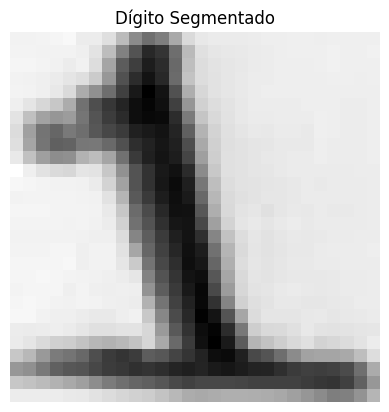

In [95]:
plt.imshow(digit_images[38], cmap='gray')
plt.title("Dígito Segmentado")  
plt.axis('off')  # Ocultar los ejes
plt.show()

In [96]:
# Crear etiquetas: asumir que hay 20 ejemplos por dígito (0-9)
labels = np.repeat(np.arange(10), 20)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(digit_images, labels, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 28, 28, 1)  # Añadir dimensión de canal
X_test = X_test.reshape(-1, 28, 28, 1)

In [97]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # Rotación de hasta 10 grados
    width_shift_range=0.1,  # Desplazamiento horizontal de hasta 10%
    height_shift_range=0.1,  # Desplazamiento vertical de hasta 10%
    zoom_range=0.1  # Escalado de hasta 10%
)

datagen.fit(X_train)

In [103]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases para los dígitos 0-9
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo usando el generador de datos
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50, validation_data=(X_test, y_test))

Epoch 1/50


c:\Users\josia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\josia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1168 - loss: 2.3085 - val_accuracy: 0.0750 - val_loss: 2.3847
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2086 - loss: 2.2889 - val_accuracy: 0.0750 - val_loss: 2.3516
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2345 - loss: 2.2660 - val_accuracy: 0.2000 - val_loss: 2.3464
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3806 - loss: 2.2363 - val_accuracy: 0.3000 - val_loss: 2.3008
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4688 - loss: 2.2086 - val_accuracy: 0.3250 - val_loss: 2.2697
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4414 - loss: 2.1363 - val_accuracy: 0.3250 - val_loss: 2.2071
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5378 - loss: 2.0741 - val_accuracy: 0.3000 - val_loss: 2.1329
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4826 - loss: 1.9673 - val_accuracy: 0.3000 - val_loss: 1.9957
Epoch 9/50


In [104]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9729 - loss: 0.1902
Precisión en el conjunto de prueba: 0.98


In [105]:
id_images = load_and_segment_images(["id.jpg"])
predicciones=model.predict(id_images)
predicciones_clases = np.argmax(predicciones, axis=1)
print("Predicciones:", predicciones_clases)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicciones: [5 9 9 6 9 7 1 0]


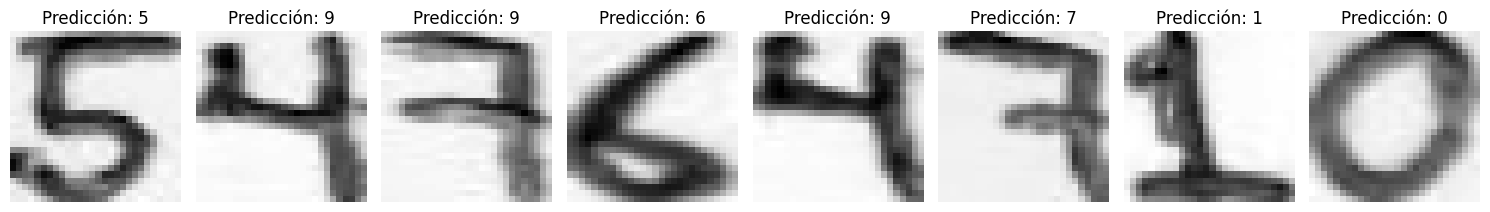

In [113]:
# Número de imágenes a mostrar
num_imagenes = 8  # Cambia este número para mostrar más o menos imágenes

# Crear subplots
fig, axes = plt.subplots(1, num_imagenes, figsize=(15, 3))  # 1 fila y 'num_imagenes' columnas
for i in range(num_imagenes):
    axes[i].imshow(id_images[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Predicción: {predicciones_clases[i]}")
    axes[i].axis('off')  # Ocultar los ejes

plt.tight_layout()  # Ajustar el espacio entre las imágenes
plt.show()